In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import scipy as sp
import imageio.v3 as imageio
import skimage as ski
from tqdm.auto import trange
import texture_segmentation.gabor as gabor
import texture_segmentation.diffusion as diffusion
import texture_segmentation.segment as segment
import texture_segmentation.data as data

imsize = 300
backgroud_id = 21
texture_id = 77

plt.rcParams['image.cmap'] = 'gray'

In [2]:
image = imageio.imread("zebra_1.png")
image = image[:, 50:-50, :3]
image = ski.color.rgb2gray(image)
zebra_img = ski.transform.resize(image, (imsize, imsize))

In [3]:
def display_result(res, image, filter_bank_params):
    # Post-process segmentation
    phi = res['phi']
    phi = ski.filters.gaussian(phi, 5)

    boarder = ski.segmentation.mark_boundaries(image, phi <= 0, color=(1, 0, 0), mode='thick')


    # Display Gabor Features
    gabor_features = res['gabor_features']
    fig, axs = plt.subplots(
        nrows=filter_bank_params['num_scales'], 
        ncols=filter_bank_params['num_angles'], 
        figsize=(30, 8)
    )
    axs = axs.flatten()
    for i in range(len(gabor_features)):
        axs[i].imshow(gabor_features[i], cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Display high-level features
    high_level_features = res['hl_features']
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=high_level_features.shape[0], 
        figsize=(15, 5)
    )
    for i in range(high_level_features.shape[0]):
        axs[i].imshow(high_level_features[i], cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Display results
    plt.imshow(boarder)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Display edges
    edges = res["edges"]
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_frequency_response(bank_params, imsize=300):
    arr = gabor.plot_gabor_filter_bank_fft_fwhm(300, **bank_params)
    yy, xx = np.mgrid[-imsize//2:imsize//2, -imsize//2:imsize//2]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    # ax.imshow(arr, cmap="binary")
    ax.pcolormesh(xx, -yy, arr, cmap="binary")
    # ax.set_axis_off()
    ax.set_xlabel(r"$f_x \quad \mathrm{px}^{-1} $")
    ax.set_ylabel(r"$f_y \quad \mathrm{px}^{-1} $")
    plt.tight_layout()
    plt.show()

# Geodesic Snakes

## High Level Features

https://www.ux.uis.no/~tranden/brodatz/D21.gif
https://www.ux.uis.no/~tranden/brodatz/D77.gif


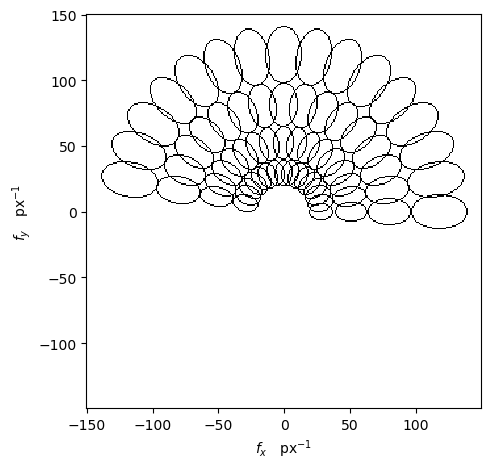

100%|██████████| 500/500 [00:03<00:00, 126.66it/s]


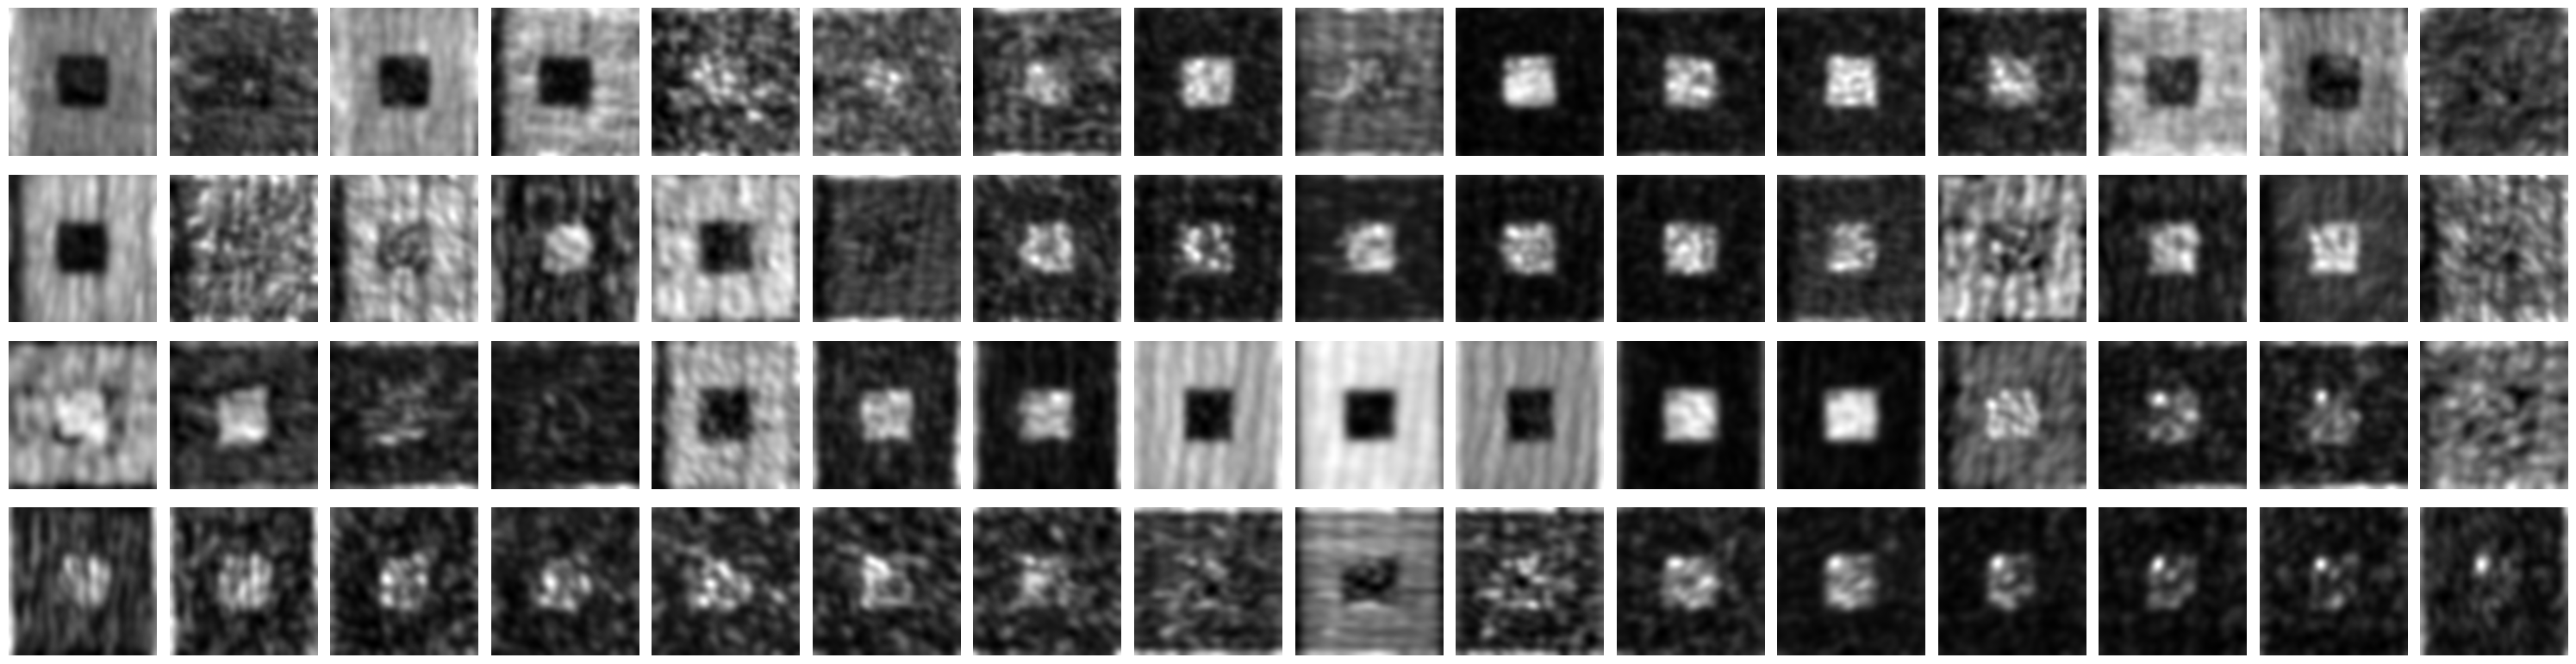

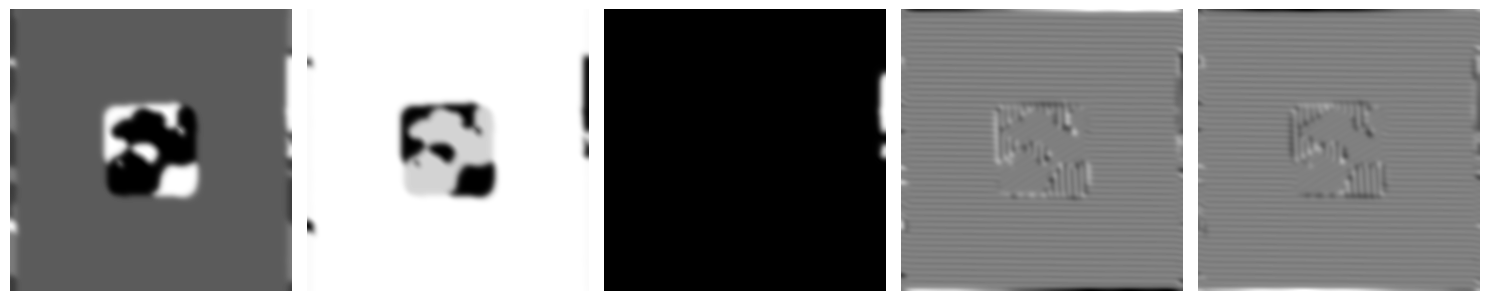

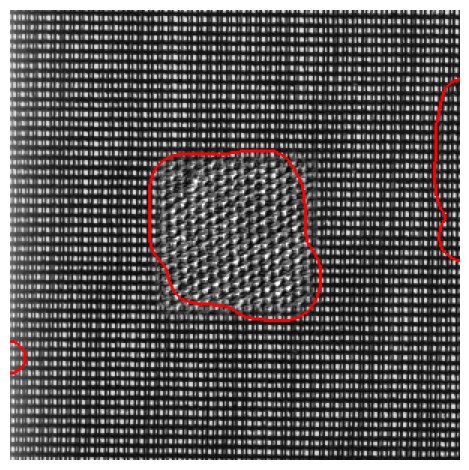

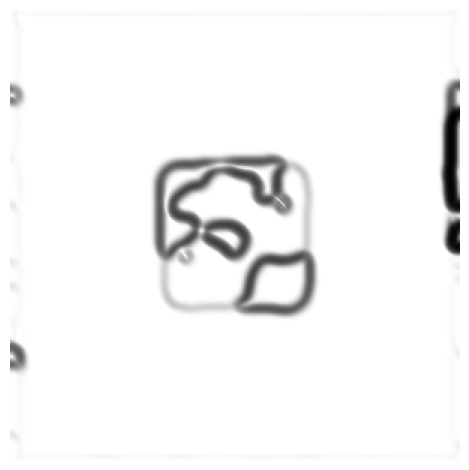

In [4]:
image = data.brodatz_test_image(backgroud_id, texture_id, imsize)

filter_bank_params = {
    'num_angles': 16,
    'full_circle': False,
    'scaling_factor': 0.6,
    'num_scales': 4,
    'sigma_x0': 0.12,
    "sigma_y0": 0.075
}
display_frequency_response(filter_bank_params, imsize=imsize)

res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.GEODESIC_SNAKES,
    feature_type=segment.FEATURE_TYPE.HIGH_LEVEL,
    initial_function="disk",
    it=500,
    eta=0.1,
    gabor_filters_params=filter_bank_params,
    lambda_c=0.65,
    mu=0.9,
)

display_result(res, image, filter_bank_params)

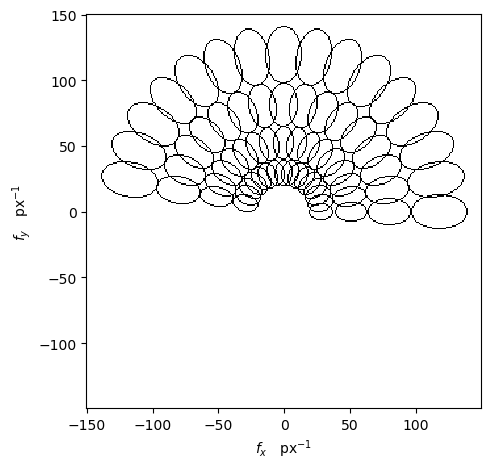

100%|██████████| 500/500 [00:03<00:00, 138.40it/s]


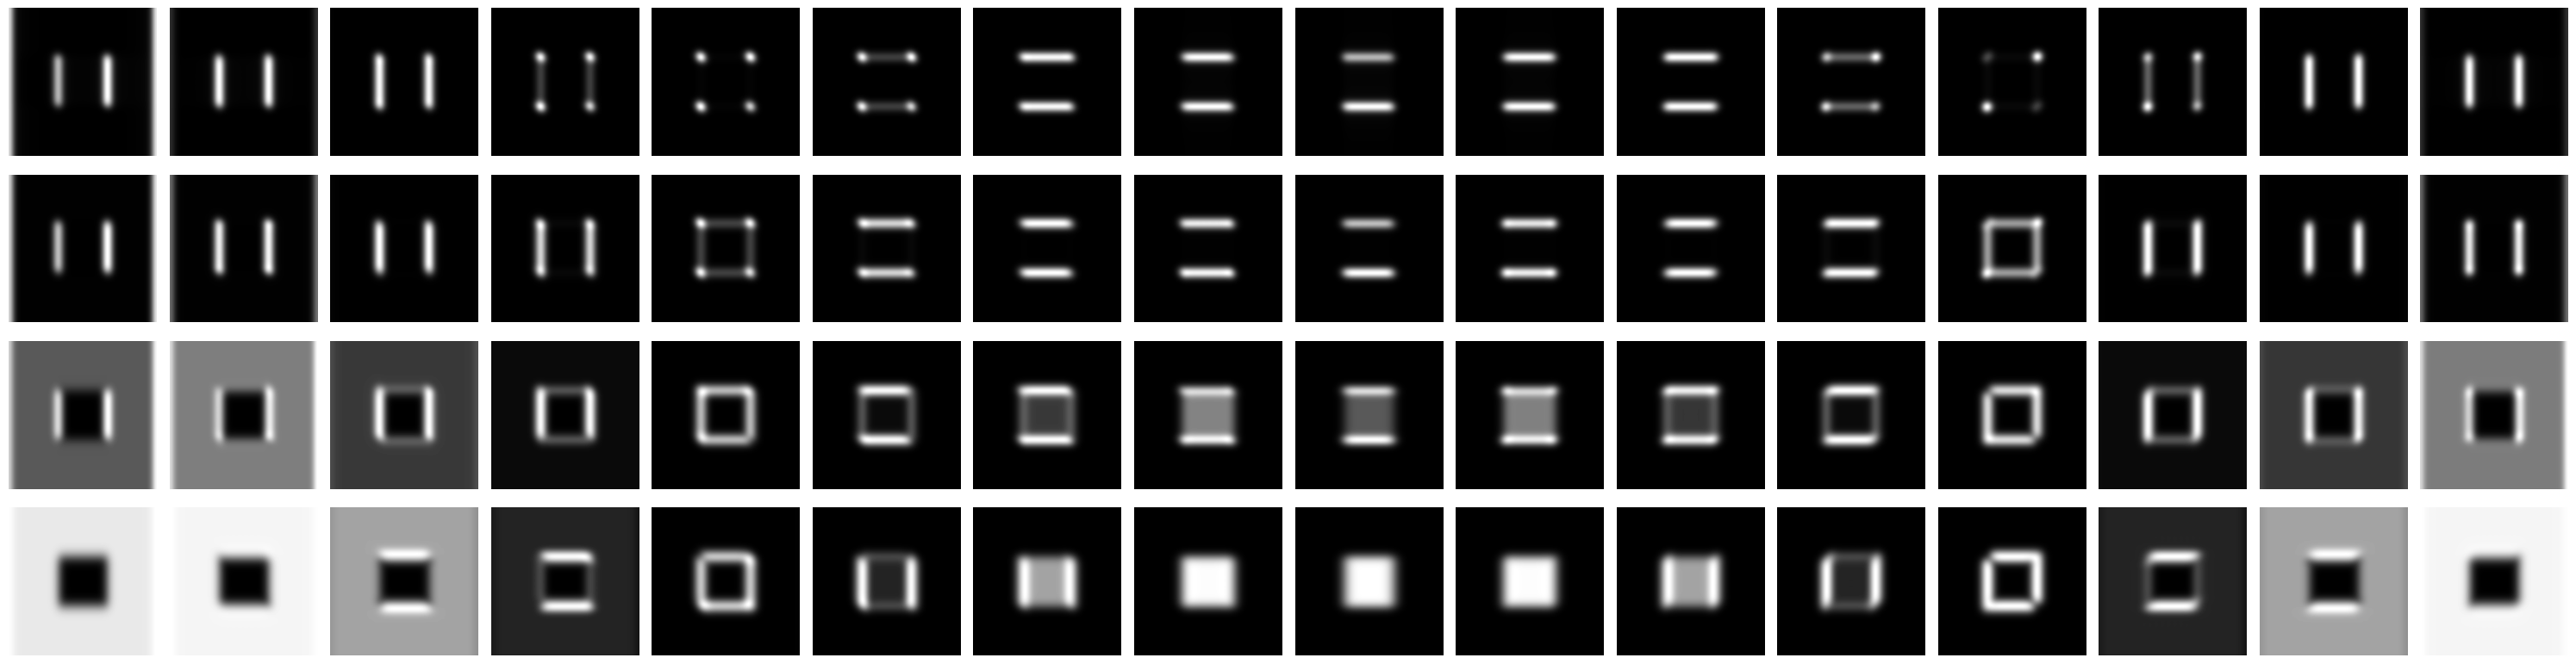

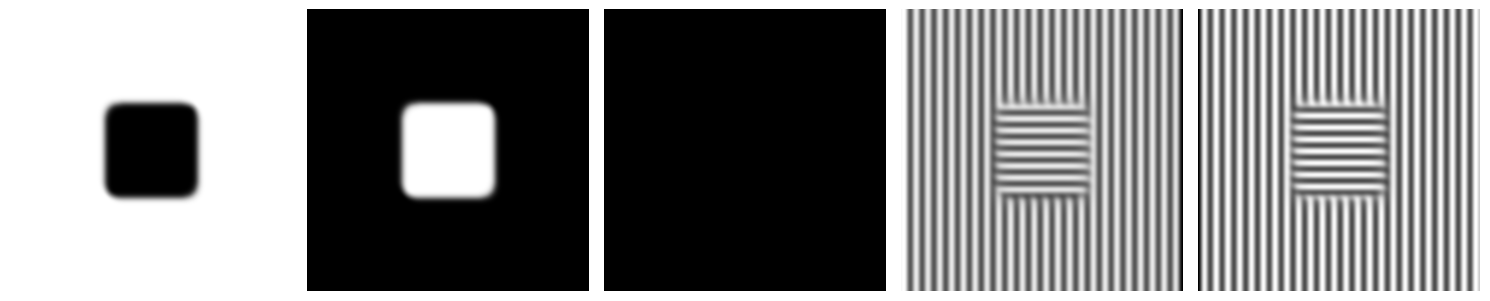

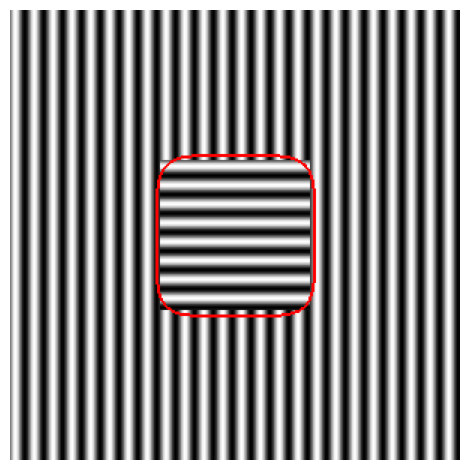

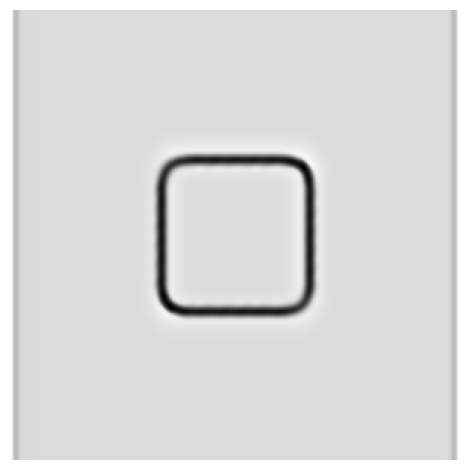

In [5]:
image = data.sine_wave_test_image(imsize)
filter_bank_params = {
    'num_angles': 16,
    'full_circle': False,
    'scaling_factor': 0.6,
    'num_scales': 4,
    'sigma_x0': 0.12,
    "sigma_y0": 0.075
}

display_frequency_response(filter_bank_params, imsize=imsize)

res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.GEODESIC_SNAKES,
    feature_type=segment.FEATURE_TYPE.HIGH_LEVEL,
    initial_function="disk",
    it=500,
    eta=0.1,
    gabor_filters_params=filter_bank_params,
    lambda_c=0.7,
    mu=0.3,
)

display_result(res, image, filter_bank_params)

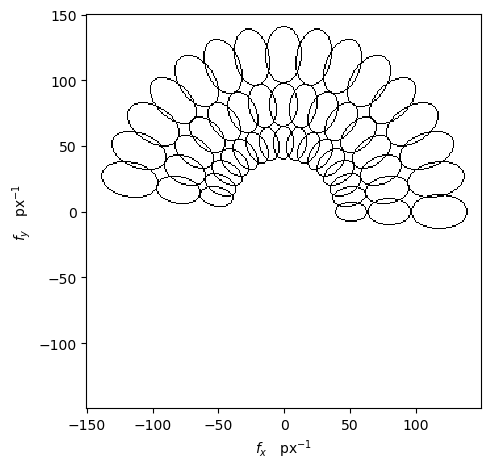

100%|██████████| 500/500 [00:04<00:00, 124.49it/s]


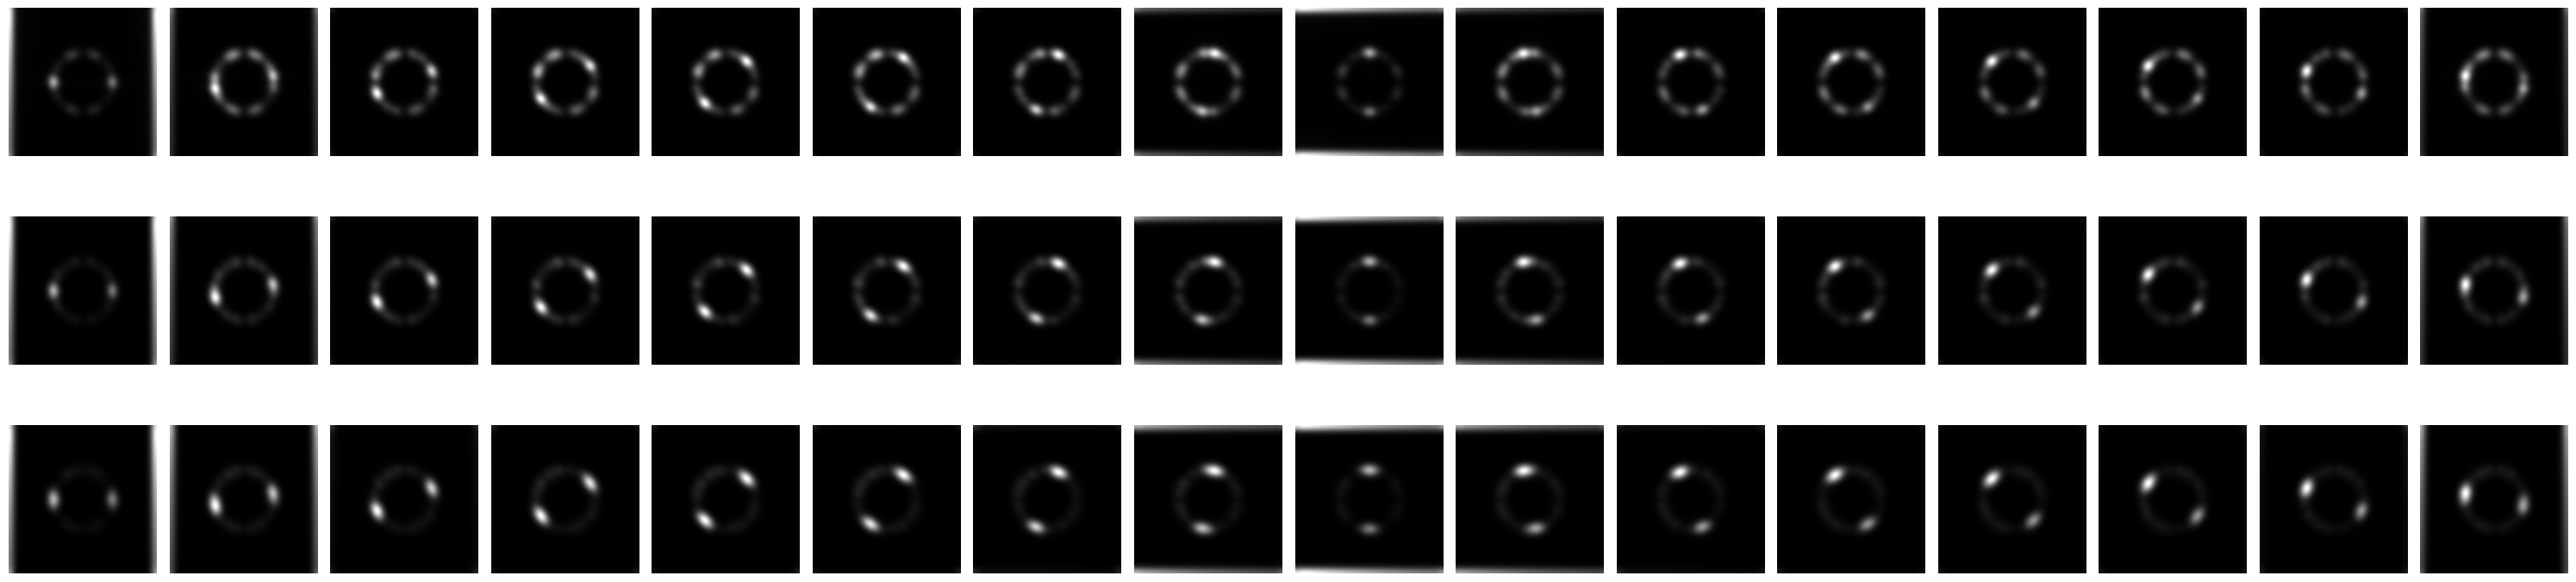

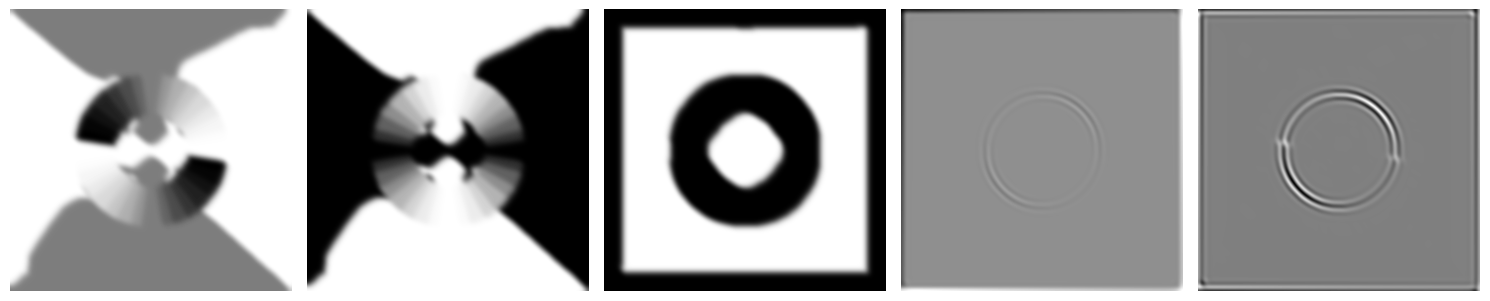

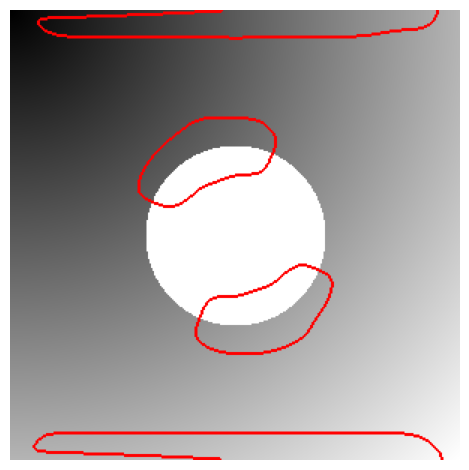

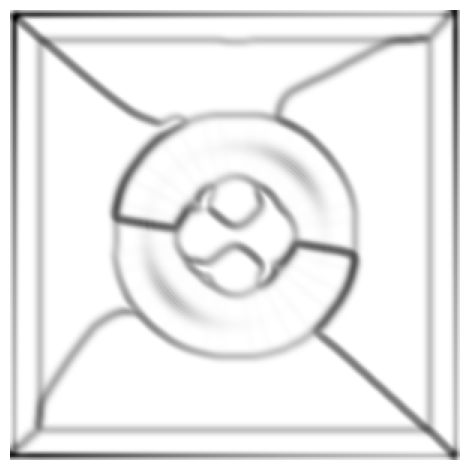

In [6]:
image = data.disk_on_gradient_test_image(imsize)
filter_bank_params = {
    'num_angles': 16,
    'full_circle': False,
    'scaling_factor': 0.6,
    'num_scales': 3,
    'sigma_x0': 0.12,
    "sigma_y0": 0.075
}

display_frequency_response(filter_bank_params, imsize=imsize)

res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.GEODESIC_SNAKES,
    feature_type=segment.FEATURE_TYPE.HIGH_LEVEL,
    initial_function="disk",
    it=500,
    eta=0.1,
    gabor_filters_params=filter_bank_params,
    lambda_c=0.25,
    mu=0.3,
)

display_result(res, image, filter_bank_params)

## Gabor Features

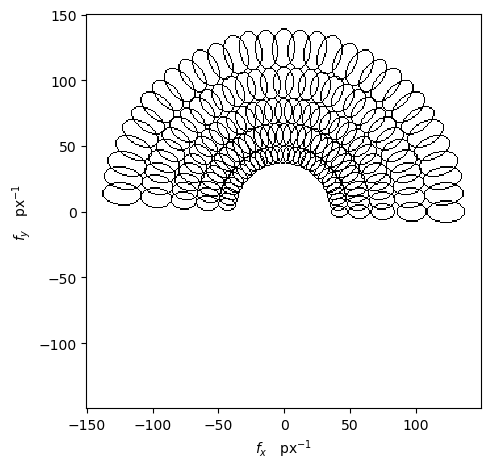

100%|██████████| 50/50 [00:08<00:00,  5.63it/s]


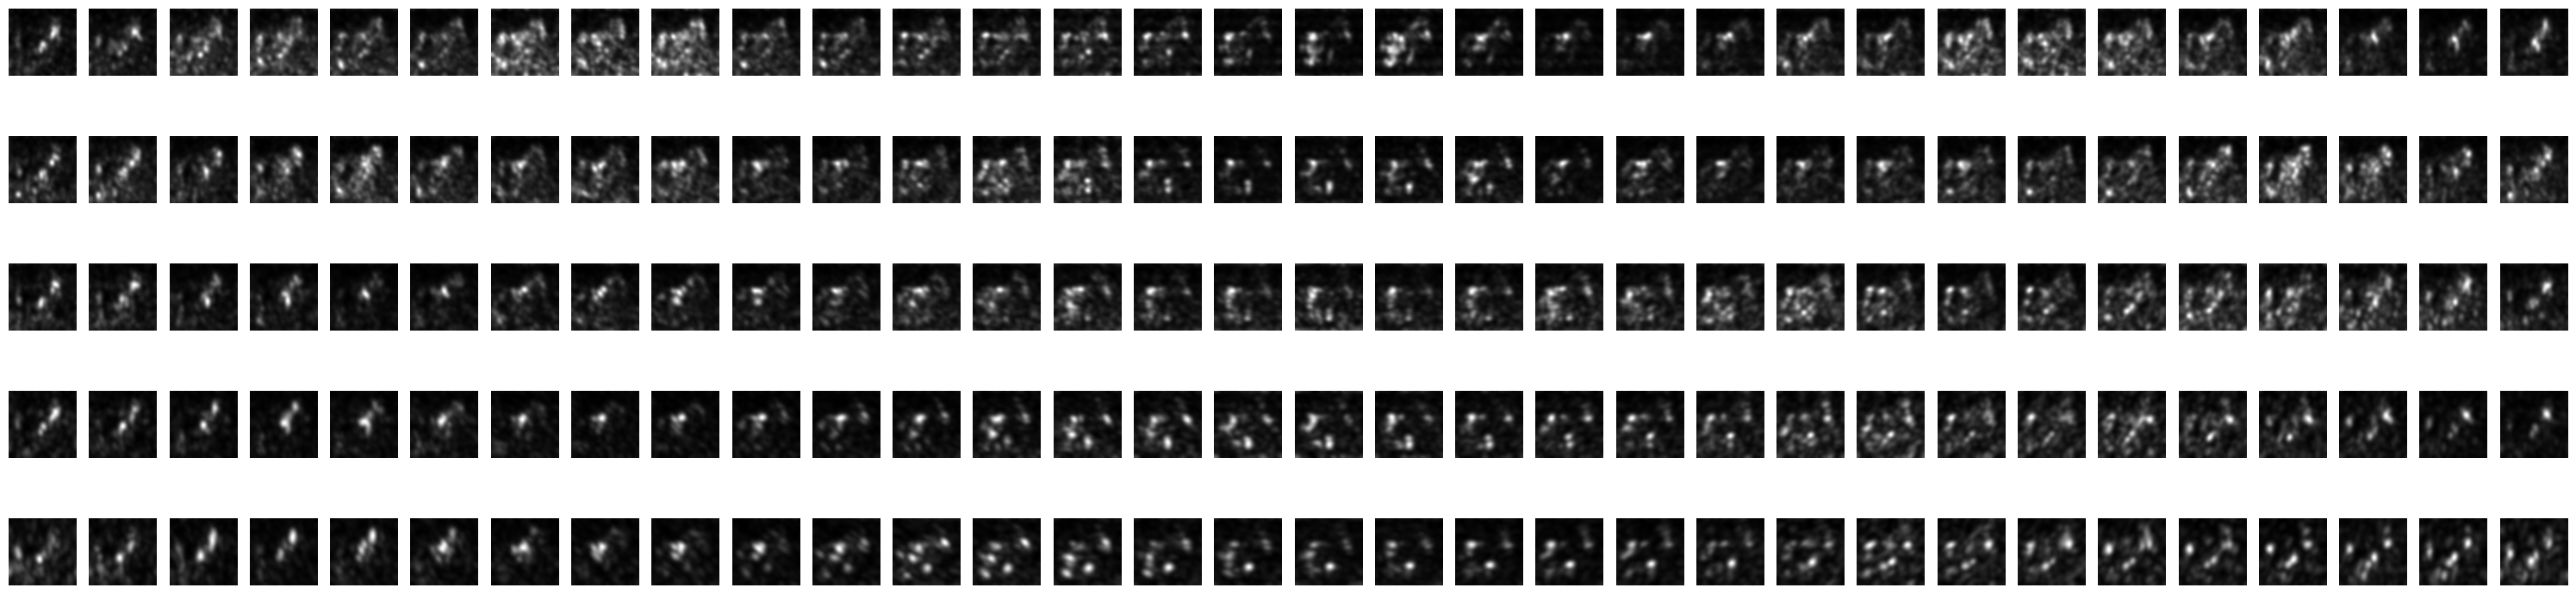

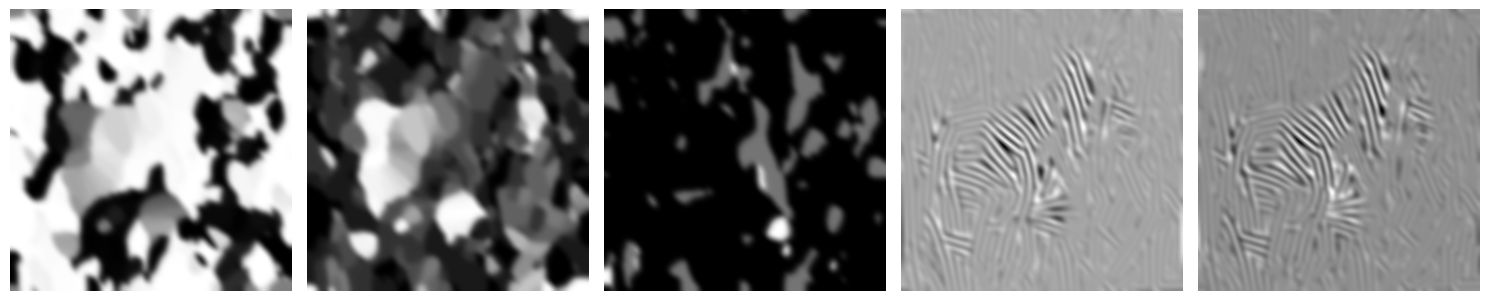

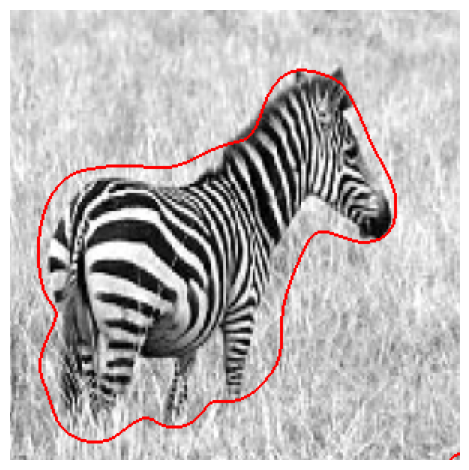

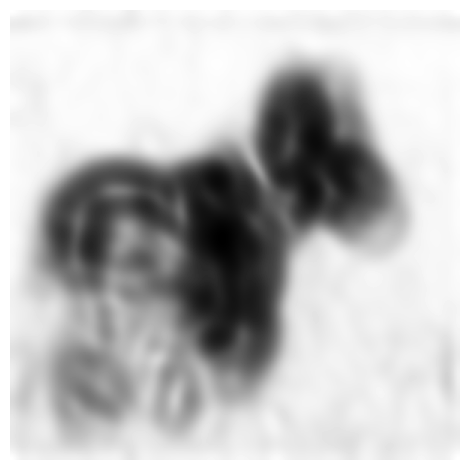

In [7]:
image = zebra_img
filter_bank_params = {
    'num_angles': 32,
    'full_circle': False,
    'scaling_factor': 0.7,
    'num_scales': 5,
    'sigma_x0': 0.08,
    "sigma_y0": 0.05
}

display_frequency_response(filter_bank_params, imsize=imsize)

res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.GEODESIC_SNAKES,
    feature_type=segment.FEATURE_TYPE.GABOR,
    initial_function="random",
    it=50,
    eta=1,
    gabor_filters_params=filter_bank_params,
    lambda_c=0.58,
    mu=0.6,
)
zebra_res = copy.deepcopy(res)

display_result(res, image, filter_bank_params)

# Active Contours

## High Level Features

https://www.ux.uis.no/~tranden/brodatz/D21.gif
https://www.ux.uis.no/~tranden/brodatz/D77.gif


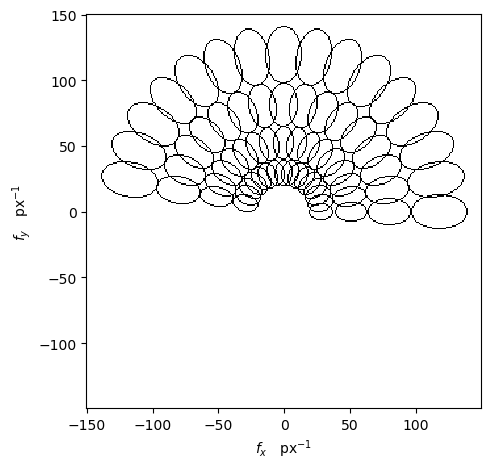

100%|██████████| 500/500 [00:04<00:00, 121.29it/s]


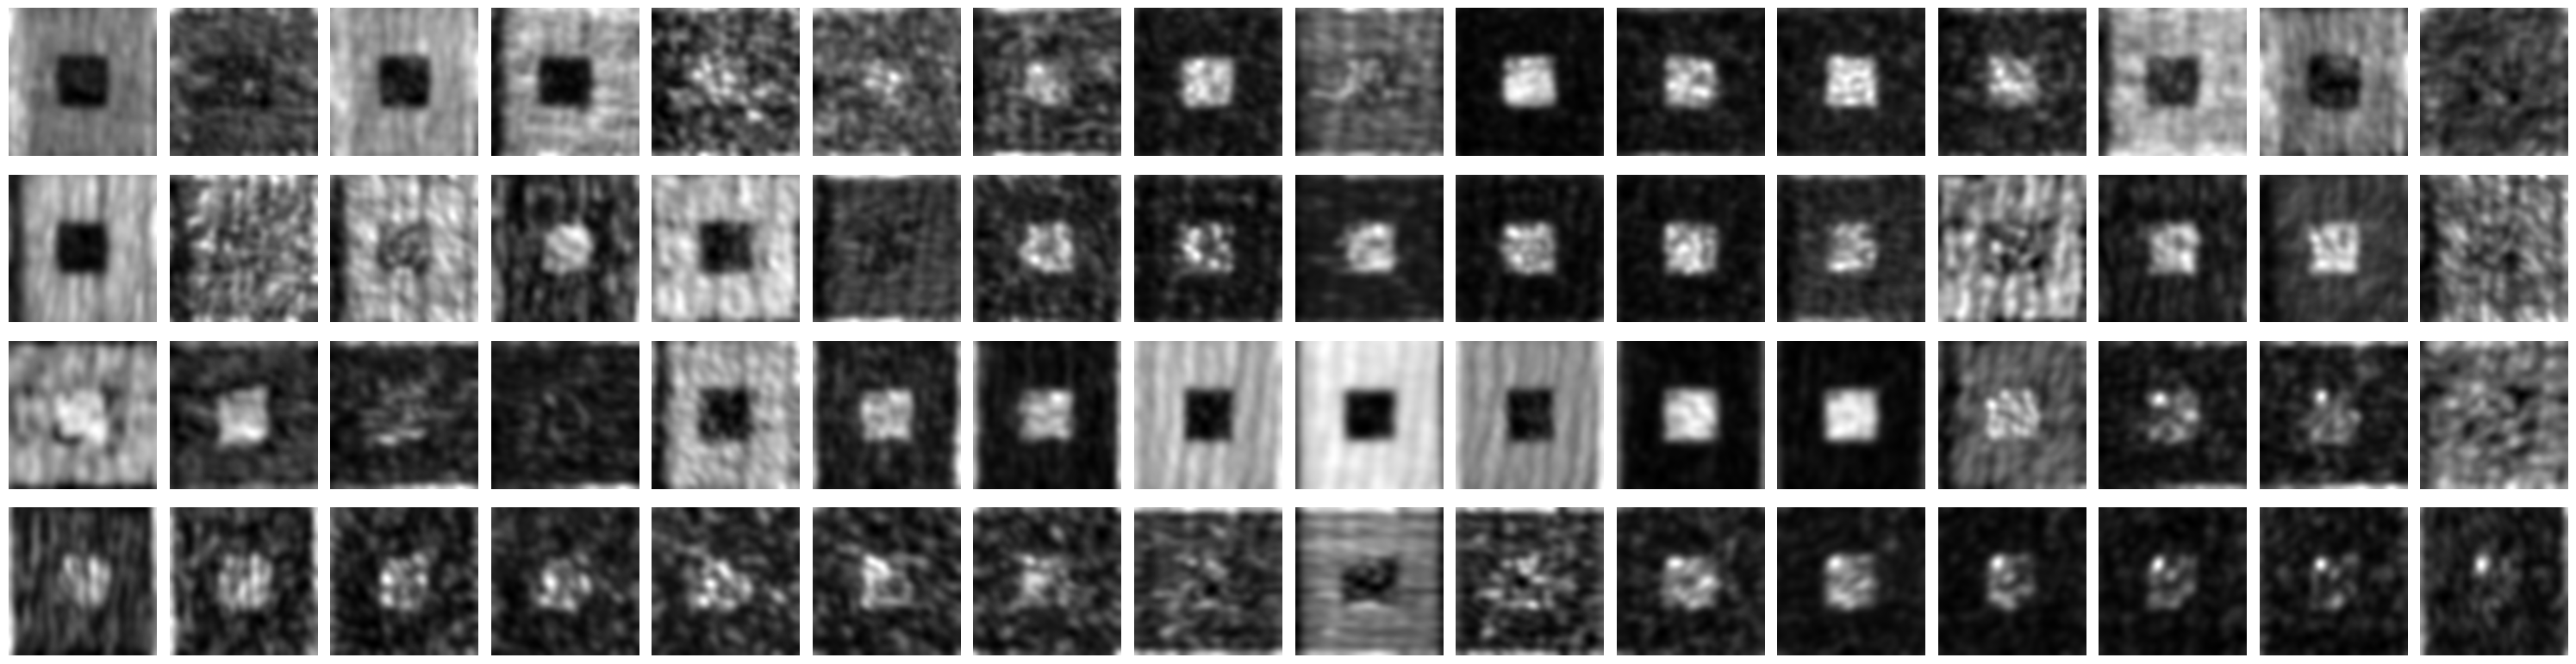

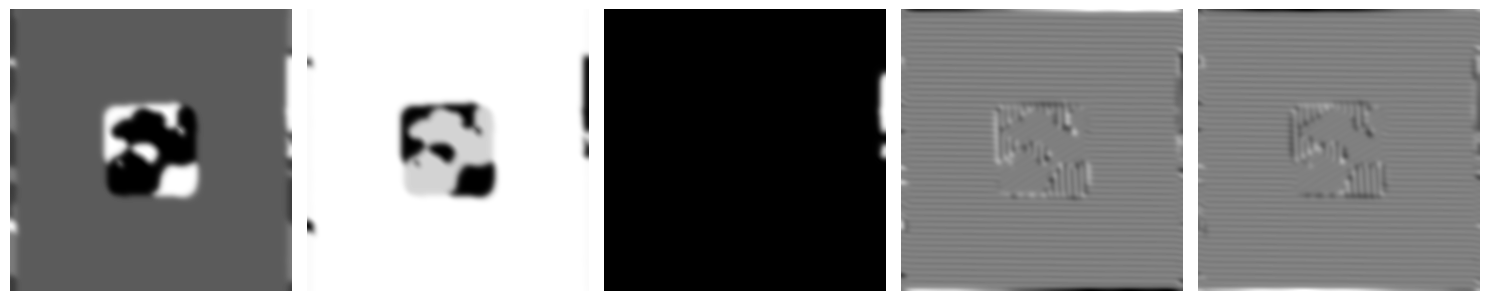

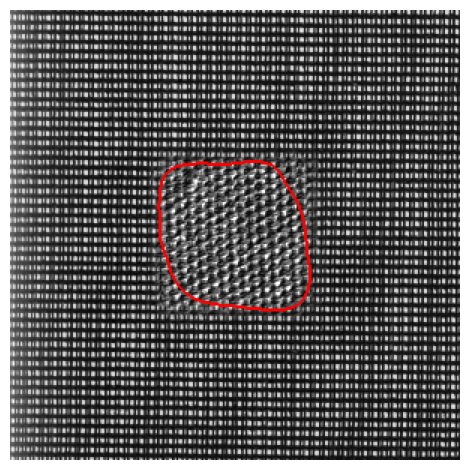

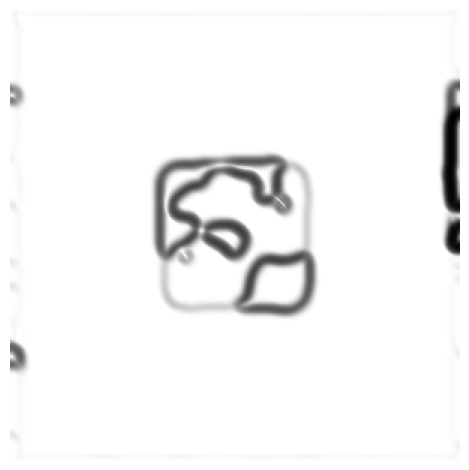

In [8]:
image = data.brodatz_test_image(backgroud_id, texture_id, imsize)
filter_bank_params = {
    'num_angles': 16,
    'full_circle': False,
    'scaling_factor': 0.6,
    'num_scales': 4,
    'sigma_x0': 0.12,
    "sigma_y0": 0.075
}

display_frequency_response(filter_bank_params, imsize=imsize)

res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.ACTIVE_CONTOURS,
    feature_type=segment.FEATURE_TYPE.HIGH_LEVEL,
    initial_function="disk",
    it=500,
    eta=3,
    gabor_filters_params=filter_bank_params,
    c=0.0
)

display_result(res, image, filter_bank_params)

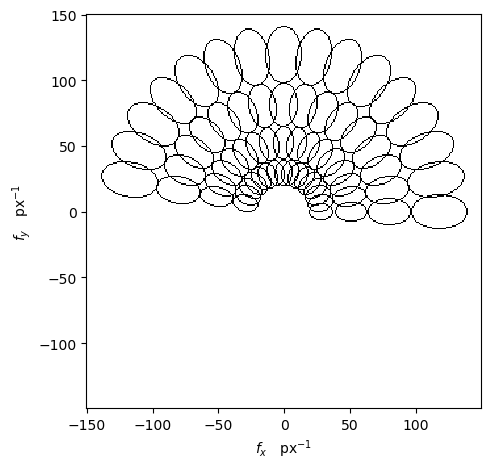

100%|██████████| 500/500 [00:03<00:00, 125.85it/s]


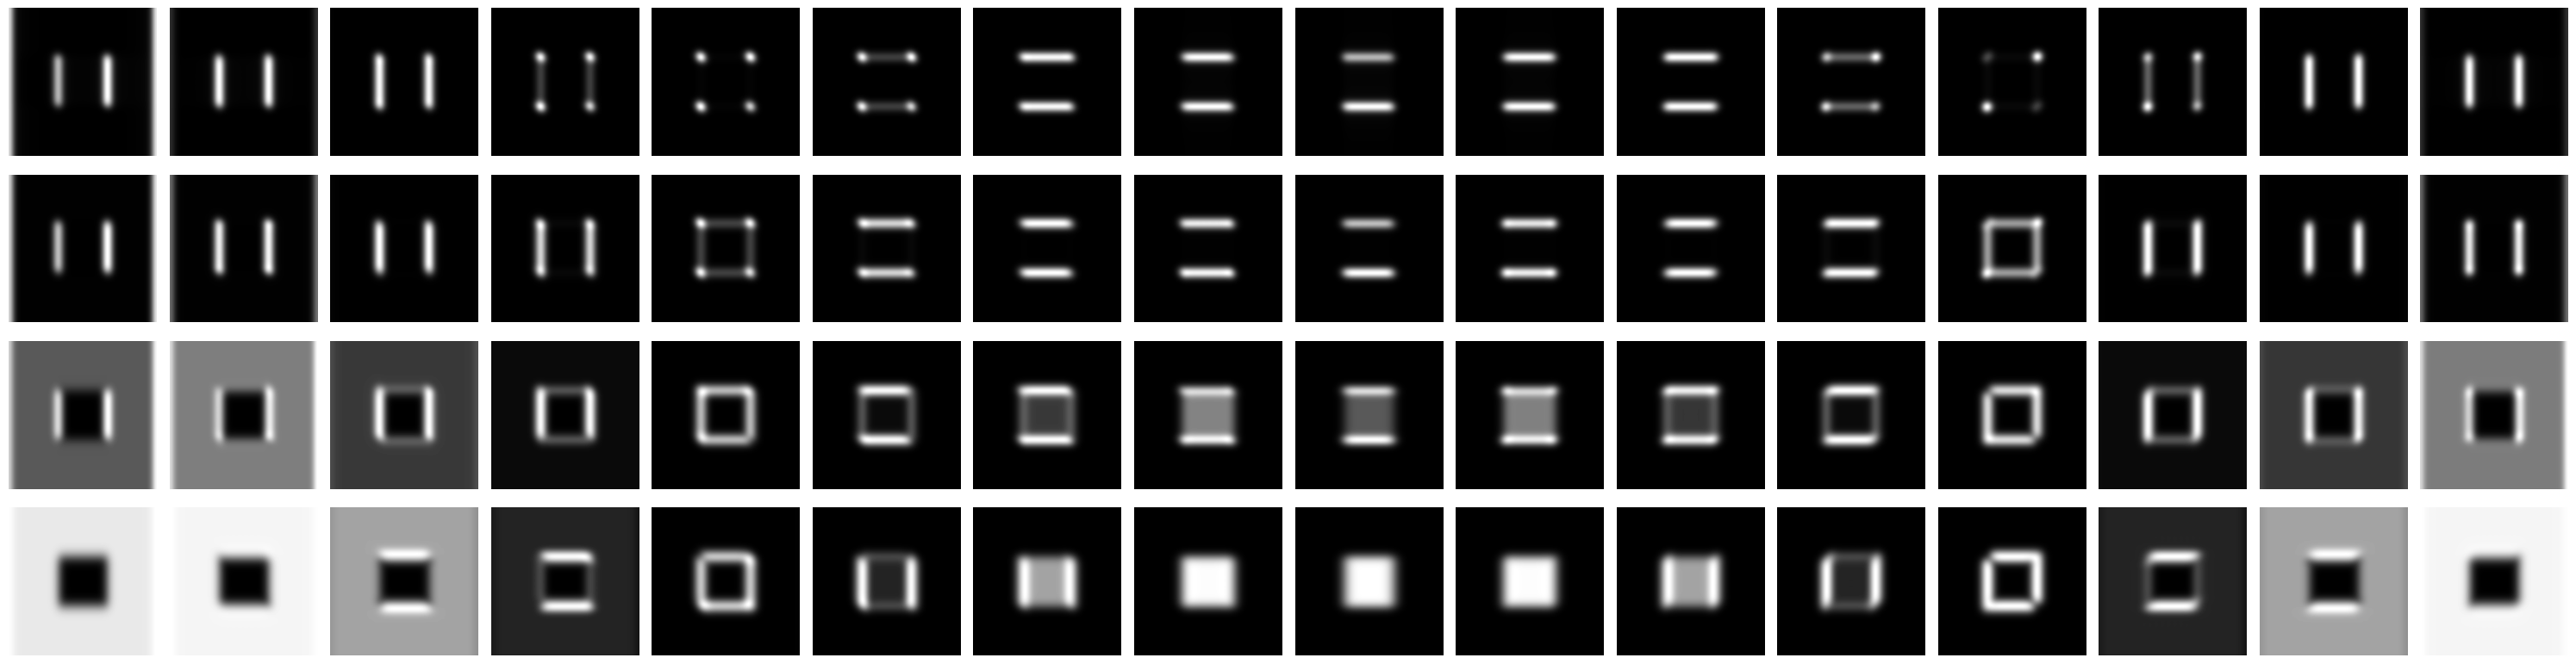

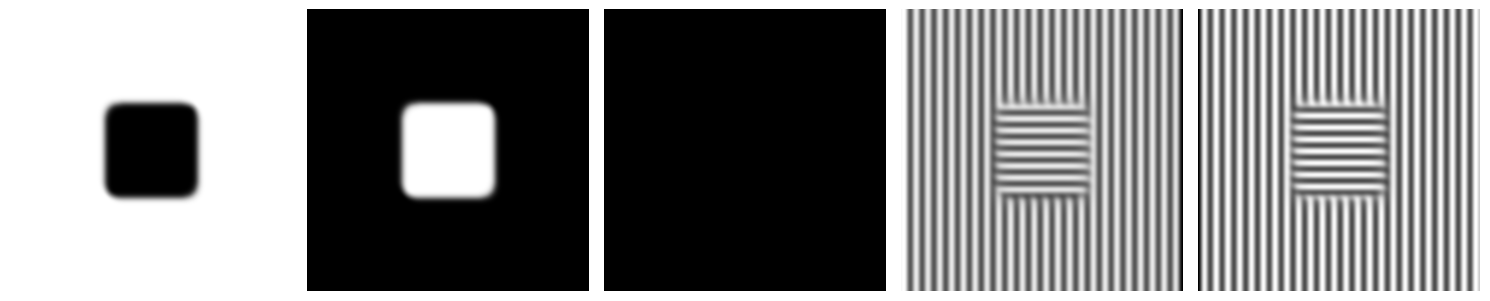

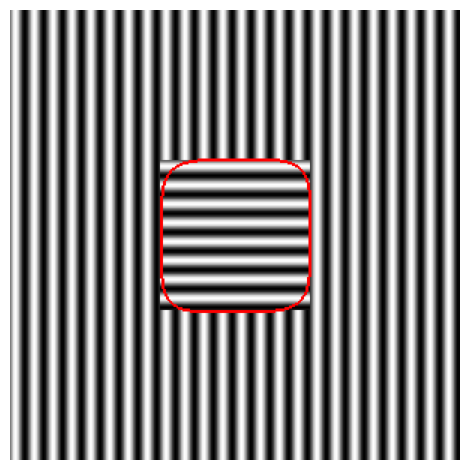

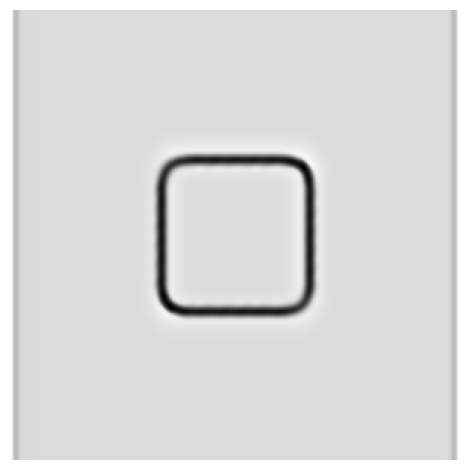

In [9]:
image = data.sine_wave_test_image(imsize)
filter_bank_params = {
    'num_angles': 16,
    'full_circle': False,
    'scaling_factor': 0.6,
    'num_scales': 4,
    'sigma_x0': 0.12,
    "sigma_y0": 0.075
}

display_frequency_response(filter_bank_params, imsize=imsize)

res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.ACTIVE_CONTOURS,
    feature_type=segment.FEATURE_TYPE.HIGH_LEVEL,
    initial_function="disk",
    it=500,
    eta=10,
    gabor_filters_params=filter_bank_params,
    c=0.0
)

display_result(res, image, filter_bank_params)

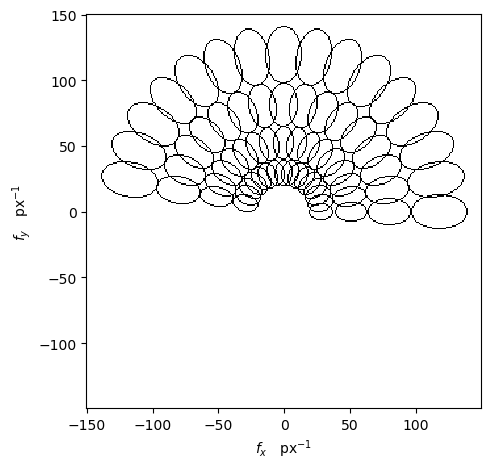

100%|██████████| 500/500 [00:04<00:00, 109.40it/s]


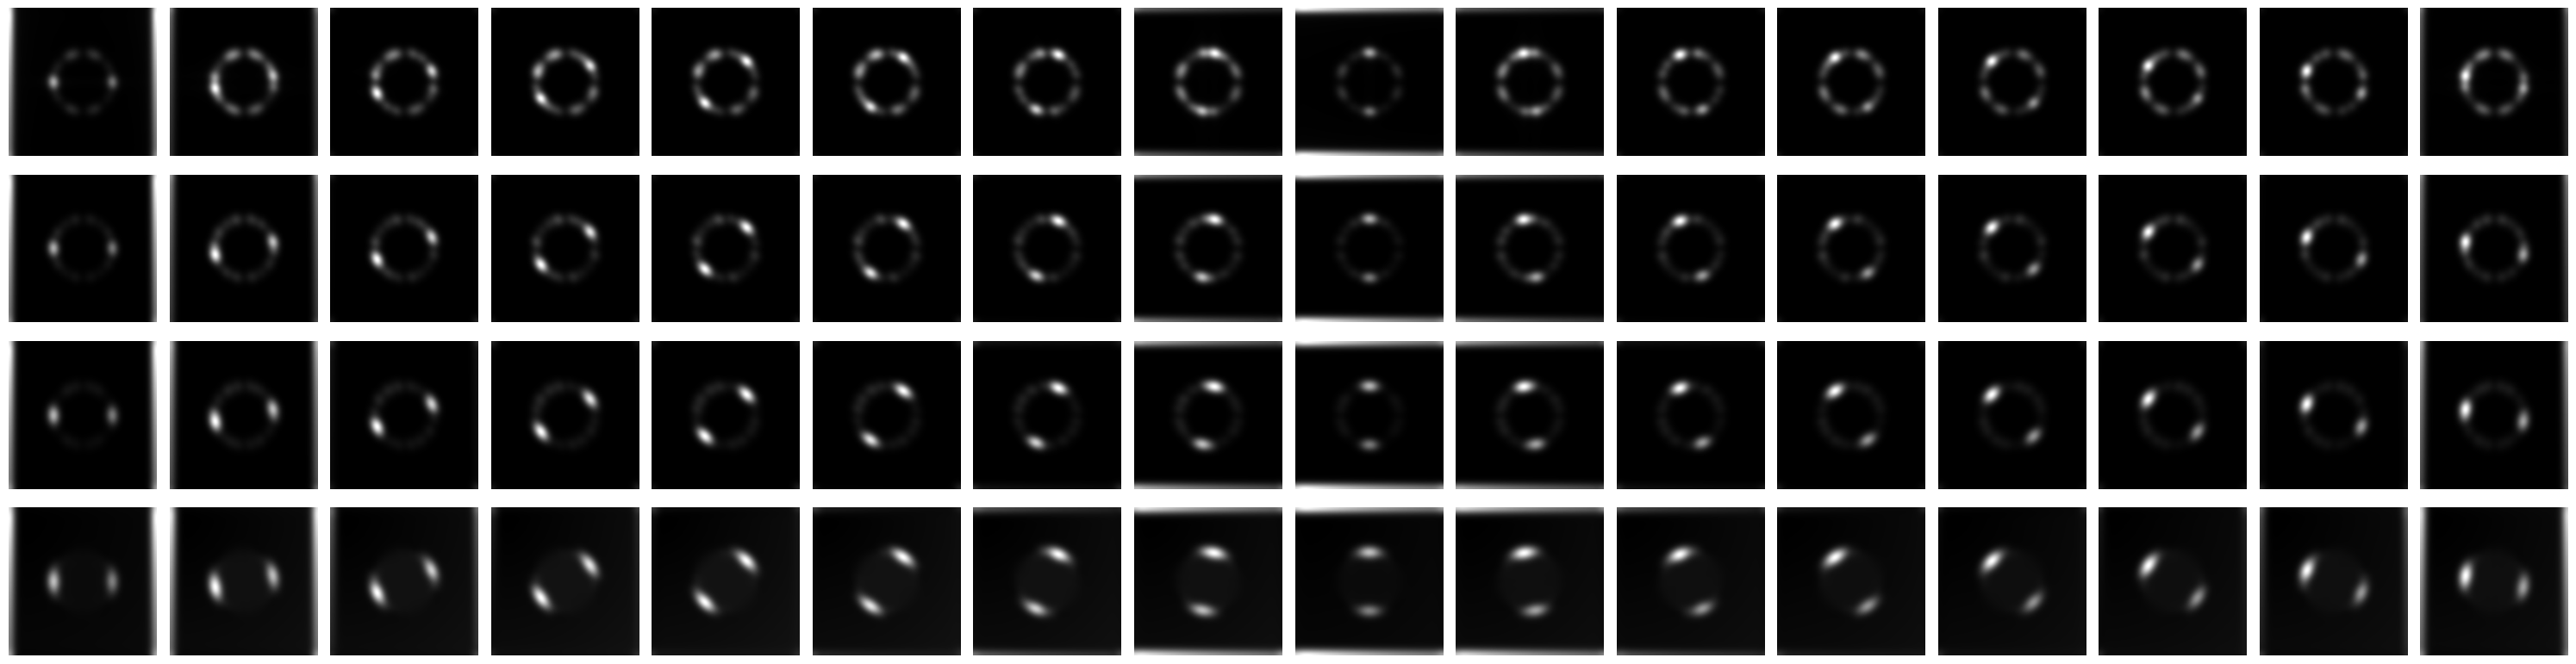

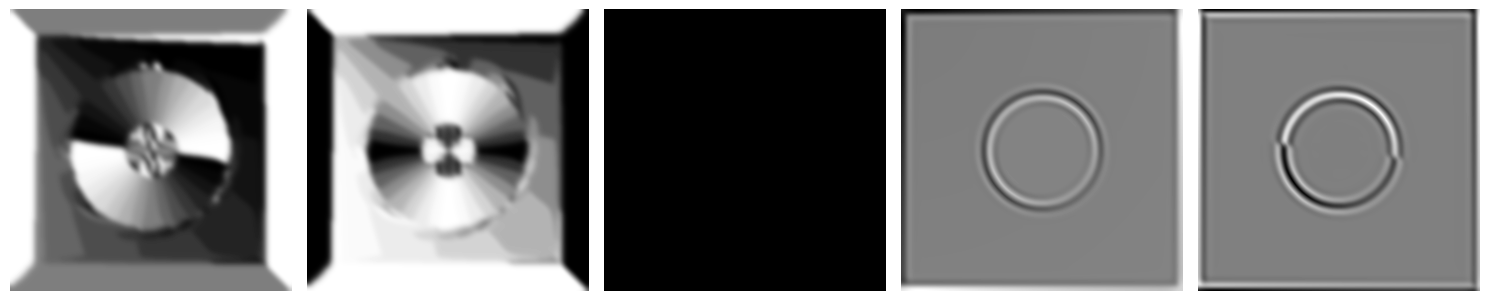

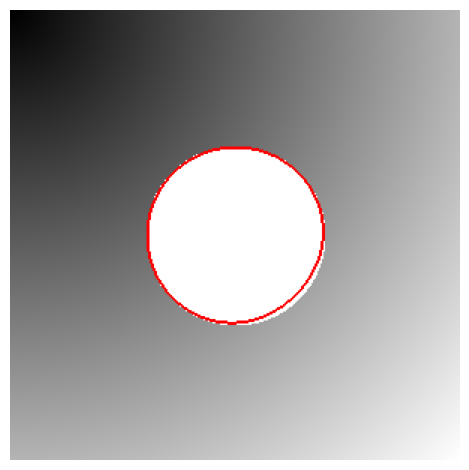

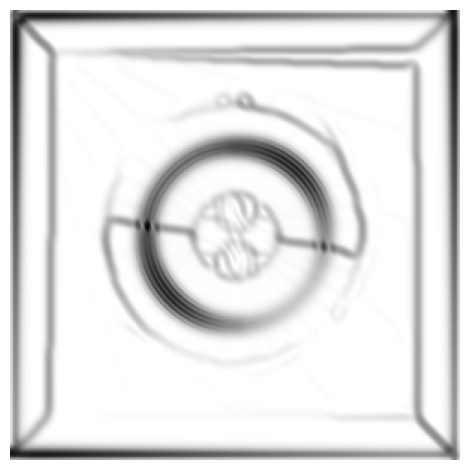

In [10]:
image = data.disk_on_gradient_test_image(imsize)
filter_bank_params = {
    'num_angles': 16,
    'full_circle': False,
    'scaling_factor': 0.6,
    'num_scales': 4,
    'sigma_x0': 0.12,
    "sigma_y0": 0.075
}

display_frequency_response(filter_bank_params, imsize=imsize)

res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.ACTIVE_CONTOURS,
    feature_type=segment.FEATURE_TYPE.HIGH_LEVEL,
    initial_function="disk",
    it=500,
    eta=5,
    gabor_filters_params=filter_bank_params,
    c=0.0
)

display_result(res, image, filter_bank_params)

Using previous result as initial function


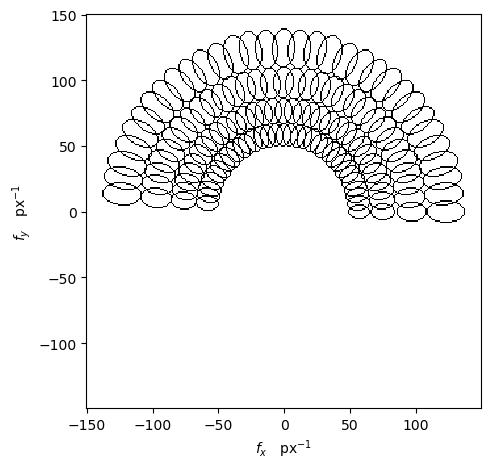

  7%|▋         | 36/500 [00:00<00:04, 112.00it/s]

100%|██████████| 500/500 [00:04<00:00, 113.98it/s]


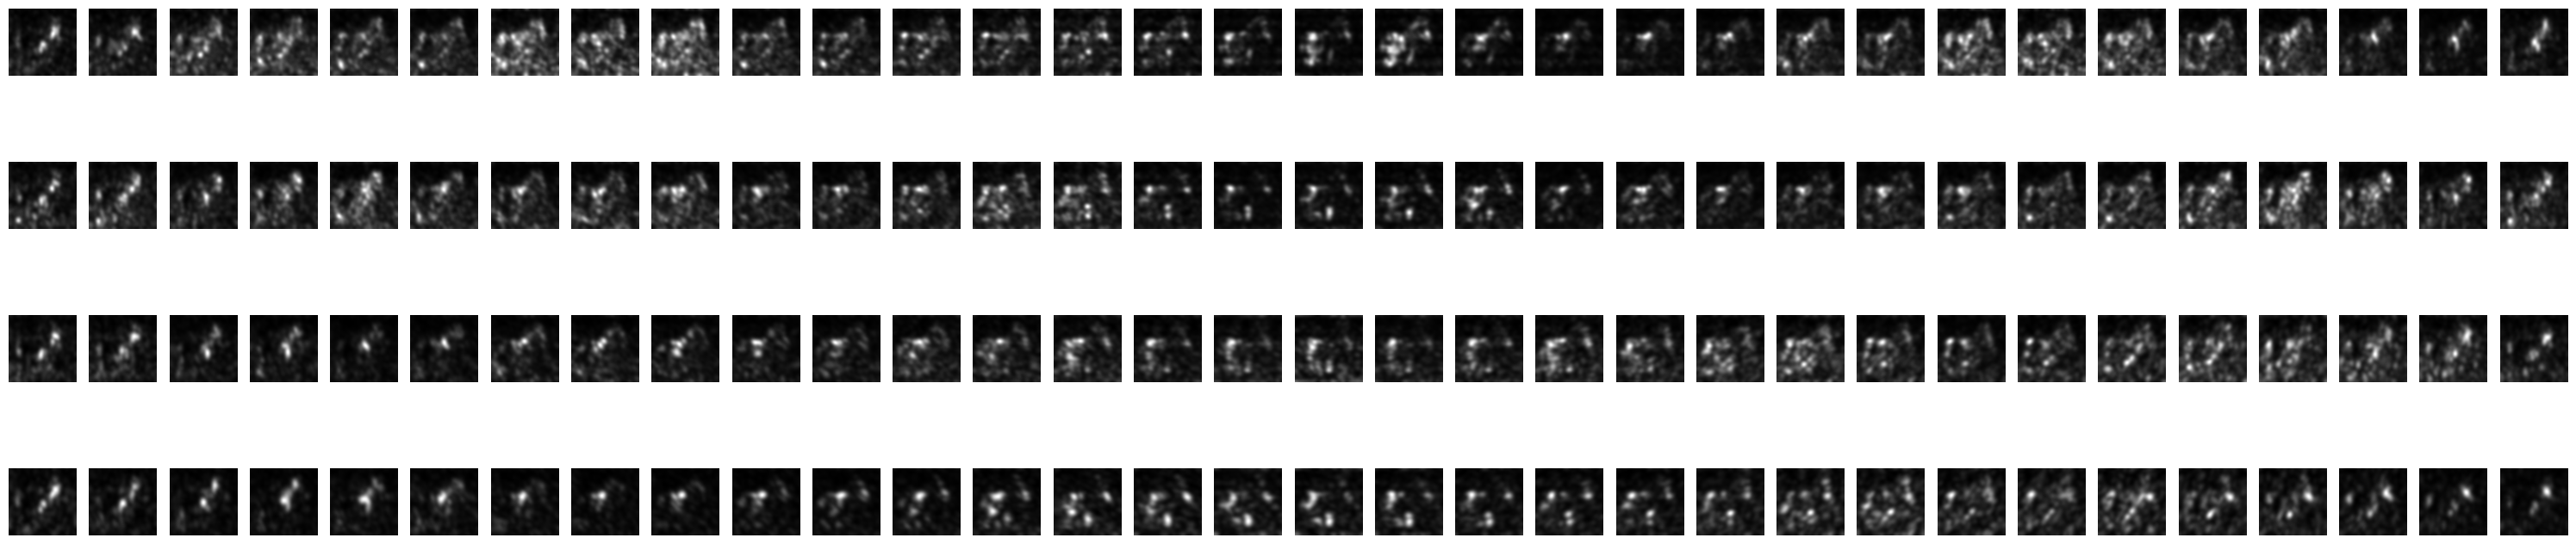

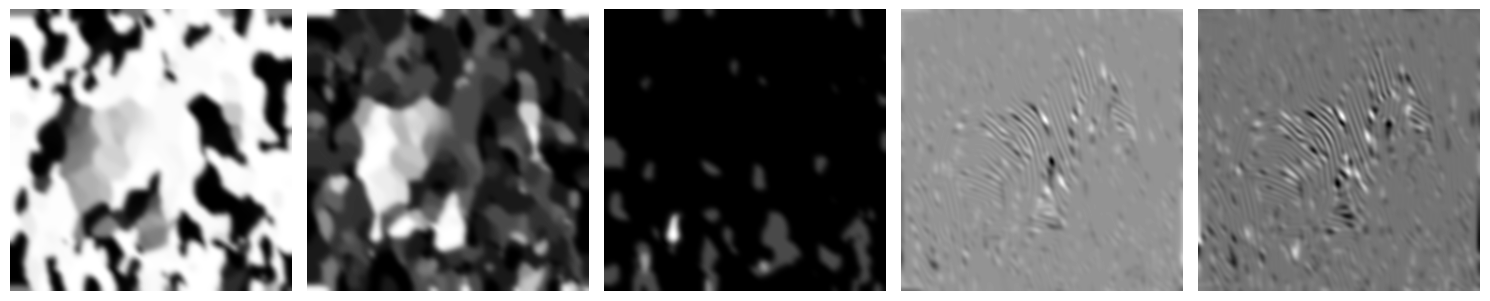

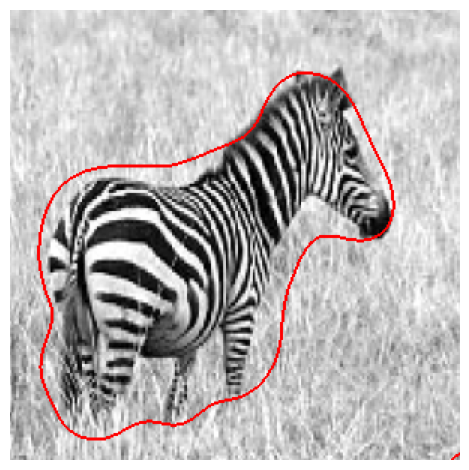

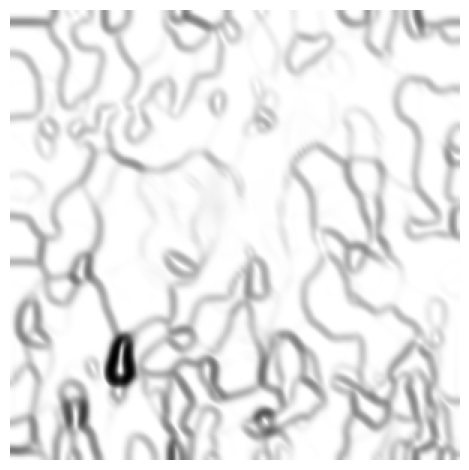

In [11]:
image = zebra_img
initial_function = "random"

try:
    initial_function = zebra_res["phi"]
    print("Using previous result as initial function")
except Exception:
    initial_function = "disk"
    print("Using disk as initial function")

filter_bank_params = {
    'num_angles': 32,
    'full_circle': False,
    'scaling_factor': 0.7,
    'num_scales': 4,
    'sigma_x0': 0.08,
    "sigma_y0": 0.05
}

display_frequency_response(filter_bank_params, imsize=imsize)

res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.ACTIVE_CONTOURS,
    feature_type=segment.FEATURE_TYPE.HIGH_LEVEL,
    initial_function=initial_function,
    it=500,
    eta=1,
    gabor_filters_params=filter_bank_params,
    c=0.0
)

display_result(res, image, filter_bank_params)